# Exploratory Analysis of Language Spoken at Home in the State of New Jersey

<hr>

## Table Of Contents

* [Loading Modules & Setting up Environment](#setup)
* [Load Data](#loaddata)
* [Clean Data](#cleandata)
* [Data visualization](#visual)
    * [Spoken Languages in the State of New Jersey](#language)
    * [Spoken Languages at the County Level in the State of New Jersey](#countylanguage)
    * [Percentage of the Population that Speaks English Very Well](#languagelevel)

## Loading Modules & Setting up Environment<a class="anchor" id="setup"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Load Data<a class="anchor" id="loaddata"></a>

Data: Language Spoken at Home<br>
Source [URL]( https://data.census.gov/cedsci/table?q=Language%20Spoken%20at%20Home&g=0400000US34.050000&tid=ACSST1Y2019.S1601&moe=false&hidePreview=false): U.S. Census Bureau, 2019 American Community Survey 1-Year Estimates<br>


In [2]:
# Load data
dataset = pd.read_csv('./data/ACSST1Y2019.S1601_data_with_overlays_2020-12-09T165359.csv', header=1)

## Clean Data<a class="anchor" id="cleandata"></a>

In [3]:
# Select the columns that we need
dataset.rename(columns={'Geographic Area Name':'All citizens 18 years old and over!!county'}, inplace=True)
dataset = dataset.filter(like='All citizens 18 years old and over', axis=1)
dataset.drop(columns=dataset.filter(like='Margin').columns, axis=1, inplace=True)

In [4]:
# Rename headers
dataset.columns = ['county',
 'total',
 'Total_Speak_only_English',
 'Total_Speak_other_language',
 'Total_Speak_other_language_Spanish',
 'Total_Speak_other_language_other',
 'Percent',
 'Percent_Speak_only_English',
 'Percent_Speak_other_language',
 'Percent_Speak_other_language_Spanish',
 'Percent_Speak_other_language_Other',
 'speak_English_very_well',
 'speak_English_very_well_only_English',
 'speak_English_very_well_other_language',
 'speak_English_very_well_other_language_Spanish',
 'speak_English_very_well_other_language_Other',
 'Percent_speak_English_very_well',
 'Percent_speak_English_very_well_only_English',
 'Percent_speak_English_very_well_other_language',
 'Percent_speak_English_very_well_other_language_Spanish',
 'Percent_speak_English_very_well_other_language_Other',
 'Speak_English_not_very_well',
 'Speak_English_not_very_well_only_English',
 'Speak_English_not_very_well_other_language',
 'Speak_English_not_very_well_other_language_Spanish',
 'Speak_English_not_very_well_other_language_Other',
 'Percent_Speak_English_not_very_well',
 'Percent_Speak_English_not_very_well_only_English',
 'Percent_Speak_English_not_very_well_other_language',
 'Percent_Speak_English_not_very_well_other_language_Spanish',
 'Percent_Speak_English_not_very_well_other_language_Other']

In [5]:
dataset.columns = list(dataset.columns.str.lower())
dataset.replace(to_replace='(X)', value='100.0', inplace=True)
dataset.replace(to_replace='N', value=np.nan, inplace=True)

In [6]:
# Convert object -> numeric
for column_name in dataset.drop(columns='county', axis=1).columns:
    dataset[column_name] = pd.to_numeric(dataset[column_name])

In [7]:
# Write dataset to csv
dataset.to_csv('./spoken_language_home.csv', index=False)

<hr>

## Data visualization<a class="anchor" id="visual"></a>

### Spoken Languages in the State of New Jersey<a class="anchor" id="language"></a>

In [8]:
# Total English, Spanish and Other Speaking Population
dataset_totals = pd.DataFrame(dataset[['total_speak_only_english',
         'total_speak_other_language_spanish',
         'total_speak_other_language_other']].sum())

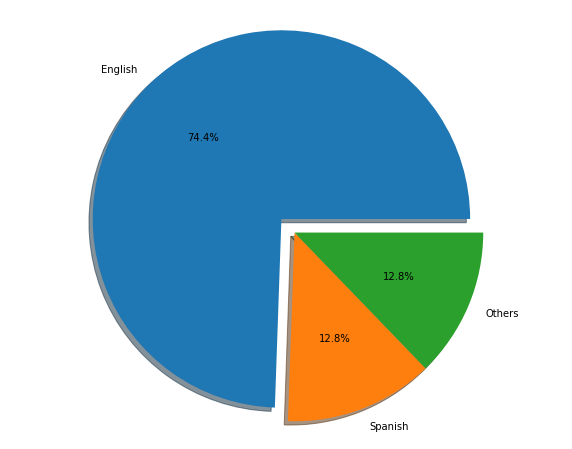

In [9]:
# Plot New Jersey - Percent Language
labels = ['English', 'Spanish', 'Others']
sizes = list((dataset_totals / dataset_totals.sum() * 100)[0])
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')

plt.show()

<br>

### Spoken Languages at the County Level in the State of New Jersey<a class="anchor" id="countylanguage"></a>

In [10]:
# Create dataset including only percent values
dataset_percent = dataset[['county',
                           'percent_speak_only_english',
                           'percent_speak_other_language_spanish',
                           'percent_speak_other_language_other']]
dataset_percent.set_index('county', inplace=True)
# Create dictionary: { County : [English %, Spanish %, Other %] } 
final_dict = {}
for county in dataset_percent.sort_values(by='percent_speak_only_english', ascending=False).index:
    final_dict[county] = [dataset_percent.loc[county,'percent_speak_only_english'],
                          dataset_percent.loc[county,'percent_speak_other_language_spanish'],
                          dataset_percent.loc[county,'percent_speak_other_language_other']]
# Remove NaN -> Salem County, New Jersey
final_dict.pop('Salem County, New Jersey', None)

[nan, nan, nan]

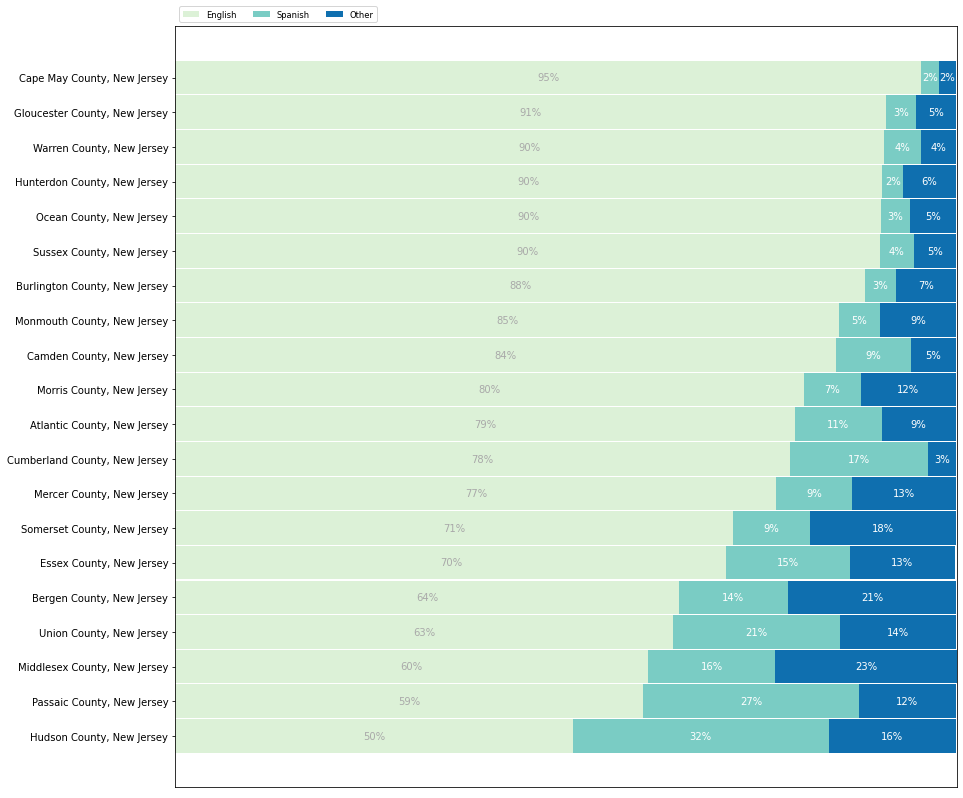

In [11]:
# Plot County vs Percent of English, Spanish, and other speaking population.
category_names = ['English','Spanish','Other']
results = final_dict


def survey(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('GnBu')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(14, 14))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.97,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c))+'%', ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()

### Percentage of the Population that Speaks English Very Well.<a class="anchor" id="languagelevel"></a>

In [12]:
# create dataset for population that speak english very well
dataset_percent_english = dataset[['county','percent_speak_english_very_well','percent_speak_english_not_very_well']]
dataset_percent_english.set_index('county', inplace=True)
# Create dictionary: { County : [English %, Spanish %, Other %] } 
final_dict = {}
for county in dataset_percent_english.sort_values(by='percent_speak_english_very_well').index:
    final_dict[county] = [dataset_percent_english.loc[county,'percent_speak_english_very_well'],
                          dataset_percent_english.loc[county,'percent_speak_english_not_very_well']]
# Remove NaN -> Salem County, New Jersey
final_dict.pop('Salem County, New Jersey', None)

[nan, nan]

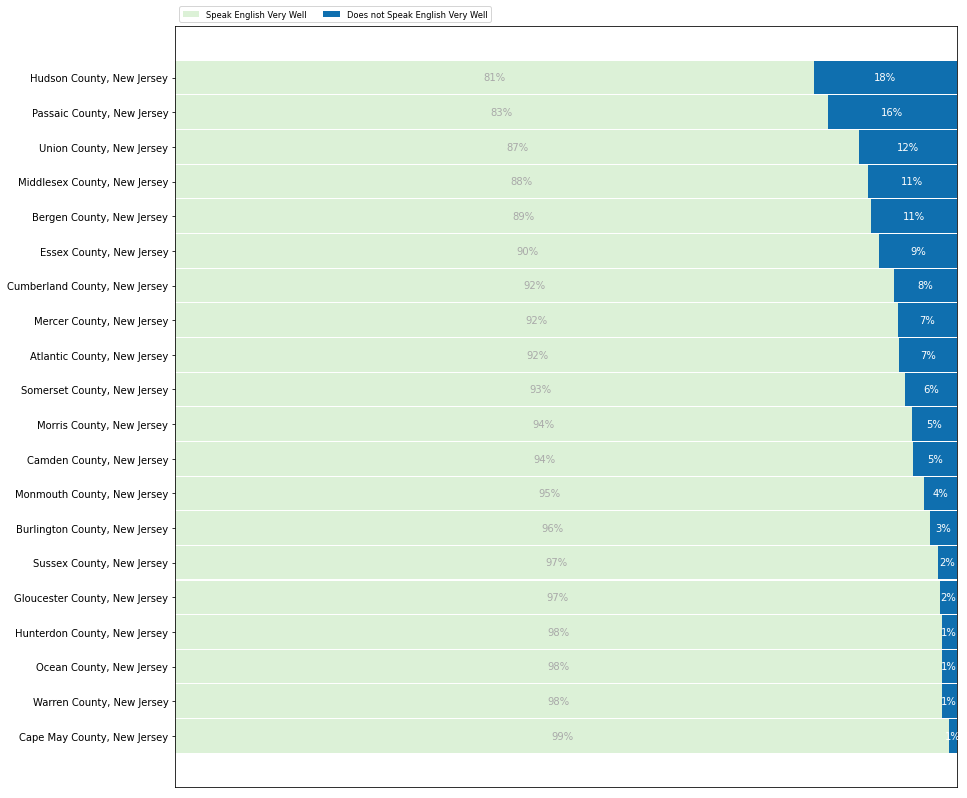

In [13]:
# Plot County vs Percent Population Speak English Very Well
category_names = ['Speak English Very Well','Does not Speak English Very Well']
results = final_dict


def survey(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('GnBu')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(14, 14))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.97,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c))+'%', ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()